In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from stocktrends import Renko
import matplotlib.pyplot as plt
import pandas as pd
import tech_ind as ti
import copy
import risk_management_utils as erk
import matplotlib.pyplot as plt

### fetching the data

In [9]:
stocks=['IOC.NS','RELIANCE.NS','TATAMOTORS.NS','BPCL.NS','HINDPETRO.NS','ONGC.NS','COALINDIA.NS','TCS.NS',
        'ICICIBANK.NS','TATASTEEL.NS','LT.NS','HINDALCO.NS','BHARTIARTL.NS','HDFCBANK.NS','M&M.NS','NTPC.NS',
        'VEDL.NS','INFY.NS','MARUTI.NS','HDFC.NS','WIPRO.NS','AXISBANK.NS','PNB.NS','JSWSTEEL.NS','BANKBARODA.NS',
        'GAIL.NS','CANBK.NS','HCLTECH.NS']
ohclv_data={}
attempt=0
drop=[] ##list of stocks whose prices were succesfully extracted
while len(stocks)!=0 and attempt<=5:
    stocks=[j for j in stocks if j not in drop]
    for i in range(len(stocks)):
        try:
            temp=yf.download(stocks[i],start='2022-10-08',interval='1d')
            temp.dropna(how='any',inplace=True)
            ohclv_data[stocks[i]]=temp   
            drop.append(stocks[i])
        except:
            print(stocks[i])
    attempt+=1
tickers=ohclv_data.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### defining the functions that are specific

In [10]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [11]:
ohlc_intra=copy.deepcopy(ohclv_data)
return_df=pd.DataFrame()
for ticker in tickers:
    print("calculating CAGR of {}....".format(ticker))
    ohlc_intra[ticker]['period_ret']=ohlc_intra[ticker]["Adj Close"].pct_change()
    return_df[ticker]=ohlc_intra[ticker]['period_ret']
return_df.dropna(inplace=True)

calculating CAGR of IOC.NS....
calculating CAGR of RELIANCE.NS....
calculating CAGR of TATAMOTORS.NS....
calculating CAGR of BPCL.NS....
calculating CAGR of HINDPETRO.NS....
calculating CAGR of ONGC.NS....
calculating CAGR of COALINDIA.NS....
calculating CAGR of TCS.NS....
calculating CAGR of ICICIBANK.NS....
calculating CAGR of TATASTEEL.NS....
calculating CAGR of LT.NS....
calculating CAGR of HINDALCO.NS....
calculating CAGR of BHARTIARTL.NS....
calculating CAGR of HDFCBANK.NS....
calculating CAGR of M&M.NS....
calculating CAGR of NTPC.NS....
calculating CAGR of VEDL.NS....
calculating CAGR of INFY.NS....
calculating CAGR of MARUTI.NS....
calculating CAGR of HDFC.NS....
calculating CAGR of WIPRO.NS....
calculating CAGR of AXISBANK.NS....
calculating CAGR of PNB.NS....
calculating CAGR of JSWSTEEL.NS....
calculating CAGR of BANKBARODA.NS....
calculating CAGR of GAIL.NS....
calculating CAGR of CANBK.NS....
calculating CAGR of HCLTECH.NS....


### defining the strategy
1. breakout rule ->price breaching 20 week rolling max/min, price in conjunction volume breaching rolling max/min volume
2. exit/stop loss ->Close price +(-) ATR(20)


#### calculate the rolling max/min price and volume

In [12]:
tickers_signal={}
tickers_ret={}
ohlc_dict=copy.deepcopy(ohlc_intra)
for ticker in tickers:
    print("Calculating ATR and rolling min/max for {}".format(ticker))
    ohlc_dict[ticker]['rolling_min']=ohlc_dict[ticker]['Close'].rolling(20).min()
    ohlc_dict[ticker]['rolling_max']=ohlc_dict[ticker]['Close'].rolling(20).max()
    ohlc_dict[ticker]['rolling_vol_max']=ohlc_dict[ticker]['Volume'].rolling(20).max()
    ohlc_dict[ticker]['ATR']=ti.ATR(ohlc_dict[ticker],n=20)
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker]=""
    tickers_ret[ticker]=[]

Calculating ATR and rolling min/max for IOC.NS
Calculating ATR and rolling min/max for RELIANCE.NS
Calculating ATR and rolling min/max for TATAMOTORS.NS
Calculating ATR and rolling min/max for BPCL.NS
Calculating ATR and rolling min/max for HINDPETRO.NS
Calculating ATR and rolling min/max for ONGC.NS
Calculating ATR and rolling min/max for COALINDIA.NS
Calculating ATR and rolling min/max for TCS.NS
Calculating ATR and rolling min/max for ICICIBANK.NS
Calculating ATR and rolling min/max for TATASTEEL.NS
Calculating ATR and rolling min/max for LT.NS
Calculating ATR and rolling min/max for HINDALCO.NS
Calculating ATR and rolling min/max for BHARTIARTL.NS
Calculating ATR and rolling min/max for HDFCBANK.NS
Calculating ATR and rolling min/max for M&M.NS
Calculating ATR and rolling min/max for NTPC.NS
Calculating ATR and rolling min/max for VEDL.NS
Calculating ATR and rolling min/max for INFY.NS
Calculating ATR and rolling min/max for MARUTI.NS
Calculating ATR and rolling min/max for HDFC.NS

In [13]:
# ## identifying signals and computing return(factroing stop loss)
# for ticker in tickers:
#     print('calculating returns for',ticker)
#     for i in range (len(df[ticker])):
#         if tickers_signal[ticker]=="":
#             tickers_ret[ticker].append(0)
#             if df[ticker]["High"][i]>=1.5*df[ticker]["rolling_max"][i] and df[ticker]["Volume"][i]>df[ticker]["rolling_vol_max"][i-1]:
#                 tickers_signal[ticker]="Buy"
#             elif df[ticker]["Low"][i]<=1.5*df[ticker]["rolling_min"][i] and df[ticker]["Volume"][i]<1.5*df[ticker]["rolling_vol_max"][i-1]:
#                 tickers_signal[ticker]="Sell"
                
#         if tickers_signal[ticker]=="Buy":
#             if df[ticker]["Low"][i]<=df[ticker]["Close"][i-1]-df[ticker]["ATR"][i-1]:
#                 tickers_signal[ticker]=""
#                 tickers_ret[ticker].append(df[ticker]["Close"][i-1]-df[ticker]["ATR"][i-1])
#             elif df[ticker]["Low"][i]<=df[ticker]["rolling_min"][i] and df[ticker]["Volume"][i]>1.5*df[ticker]["rolling_vol_max"][i-1]:
#                 tickers_signal[ticker]="Sell"
#                 tickers_ret[ticker].append(df[ticker]["Close"][i]/df[ticker]["Close"][i-1]-1)
#             else:
#                 tickers_ret[ticker].append(df[ticker]["Close"][i]/df[ticker]["Close"][i-1]-1)
                
#         elif tickers_signal[ticker]=="Sell":
#             if df[ticker]["High"][i]>df[ticker]["Close"][i-1]+df[ticker]["ATR"][i-1]:
#                 tickers_signal[ticker]=""
#                 tickers_ret[ticker].append(df[ticker]["Close"][i-1]/df[ticker]["Close"][i])
#             elif df[ticker]["High"][i]>=df[ticker]["rolling_max"][i] and df[ticker]["Volume"][i]>1.5*df[ticker]["rolling_vol_max"][i-1]:
#                 tickers_signal[ticker]="Buy"
#                 tickers_ret[ticker].append(df[ticker]["Close"][i-1]/df[ticker]["Close"][i]-1)
#             else:
#                 tickers_ret[ticker].append(df[ticker]["Close"][i]/df[ticker]["Close"][i-1]-1)
        

In [14]:
a=1.25
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["rolling_max"][i] and \
               ohlc_dict[ticker]["Volume"][i]>a*ohlc_dict[ticker]["rolling_vol_max"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["rolling_min"][i] and \
               ohlc_dict[ticker]["Volume"][i]>a*ohlc_dict[ticker]["rolling_vol_max"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["rolling_min"][i] and \
               ohlc_dict[ticker]["Volume"][i]>a*ohlc_dict[ticker]["rolling_vol_max"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["rolling_max"][i] and \
               ohlc_dict[ticker]["Volume"][i]>a*ohlc_dict[ticker]["rolling_vol_max"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])



calculating returns for  IOC.NS
calculating returns for  RELIANCE.NS
calculating returns for  TATAMOTORS.NS
calculating returns for  BPCL.NS
calculating returns for  HINDPETRO.NS
calculating returns for  ONGC.NS
calculating returns for  COALINDIA.NS
calculating returns for  TCS.NS
calculating returns for  ICICIBANK.NS
calculating returns for  TATASTEEL.NS
calculating returns for  LT.NS
calculating returns for  HINDALCO.NS
calculating returns for  BHARTIARTL.NS
calculating returns for  HDFCBANK.NS
calculating returns for  M&M.NS
calculating returns for  NTPC.NS
calculating returns for  VEDL.NS
calculating returns for  INFY.NS
calculating returns for  MARUTI.NS
calculating returns for  HDFC.NS
calculating returns for  WIPRO.NS
calculating returns for  AXISBANK.NS
calculating returns for  PNB.NS
calculating returns for  JSWSTEEL.NS
calculating returns for  BANKBARODA.NS
calculating returns for  GAIL.NS
calculating returns for  CANBK.NS
calculating returns for  HCLTECH.NS


In [15]:
strategy_df=pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker]=ohlc_dict[ticker]['ret']
    tickers_ret[ticker].clear()
strategy_df['ret']=strategy_df.mean(axis=1)
print(CAGR(strategy_df),sharpe(strategy_df,0.03))

-0.8763484767915728 -5.30175230232955


<AxesSubplot:xlabel='Date'>

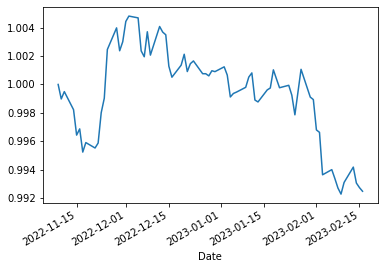

In [16]:
(1+strategy_df['ret']).cumprod().plot()

In [17]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  IOC.NS
calculating KPIs for  RELIANCE.NS
calculating KPIs for  TATAMOTORS.NS
calculating KPIs for  BPCL.NS
calculating KPIs for  HINDPETRO.NS
calculating KPIs for  ONGC.NS
calculating KPIs for  COALINDIA.NS
calculating KPIs for  TCS.NS
calculating KPIs for  ICICIBANK.NS
calculating KPIs for  TATASTEEL.NS
calculating KPIs for  LT.NS
calculating KPIs for  HINDALCO.NS
calculating KPIs for  BHARTIARTL.NS
calculating KPIs for  HDFCBANK.NS
calculating KPIs for  M&M.NS
calculating KPIs for  NTPC.NS
calculating KPIs for  VEDL.NS
calculating KPIs for  INFY.NS
calculating KPIs for  MARUTI.NS
calculating KPIs for  HDFC.NS
calculating KPIs for  WIPRO.NS
calculating KPIs for  AXISBANK.NS
calculating KPIs for  PNB.NS
calculating KPIs for  JSWSTEEL.NS
calculating KPIs for  BANKBARODA.NS
calculating KPIs for  GAIL.NS
calculating KPIs for  CANBK.NS
calculating KPIs for  HCLTECH.NS


/var/folders/46/9c3nkbns0892dbcsn8bbmmm00000gn/T/ipykernel_14275/492056764.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sr = (CAGR(df) - rf)/volatility(df)


,Return,Sharpe Ratio,Max Drawdown
IOC.NS,8.289206e+04,7.411708e+04,0.048687
RELIANCE.NS,-9.999999e-01,-1.526111e+00,0.067585
TATAMOTORS.NS,8.948640e+09,8.947438e+09,0.025145
BPCL.NS,2.778651e+01,2.729907e+01,0.047576
HINDPETRO.NS,-1.000000e+00,-1.636263e+00,0.064031
ONGC.NS,0.000000e+00,-inf,0.000000
COALINDIA.NS,-1.000000e+00,-6.275178e-01,0.200469
TCS.NS,0.000000e+00,-inf,0.000000
ICICIBANK.NS,7.324447e+03,6.973419e+03,0.040101
TATASTEEL.NS,-9.918869e-01,-9.590192e-01,0.051443


In [18]:
tickers_signal

{'IOC.NS': '',
 'RELIANCE.NS': '',
 'TATAMOTORS.NS': '',
 'BPCL.NS': '',
 'HINDPETRO.NS': '',
 'ONGC.NS': 'Buy',
 'COALINDIA.NS': '',
 'TCS.NS': '',
 'ICICIBANK.NS': '',
 'TATASTEEL.NS': 'Sell',
 'LT.NS': '',
 'HINDALCO.NS': 'Sell',
 'BHARTIARTL.NS': '',
 'HDFCBANK.NS': '',
 'M&M.NS': '',
 'NTPC.NS': 'Buy',
 'VEDL.NS': '',
 'INFY.NS': '',
 'MARUTI.NS': '',
 'HDFC.NS': '',
 'WIPRO.NS': '',
 'AXISBANK.NS': '',
 'PNB.NS': '',
 'JSWSTEEL.NS': '',
 'BANKBARODA.NS': '',
 'GAIL.NS': '',
 'CANBK.NS': '',
 'HCLTECH.NS': ''}

In [19]:
profit=[]
for i in range(len(lost)):
    profit.append(gained[i]-lost[i])

NameError: name 'lost' is not defined

In [ ]:
profit.index(max(profit))